# ANLY-590 Homework 2 

## Jiajia Liu collaborated with Hanjing Wang

In [0]:
# library
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten,Embedding,SimpleRNN, LSTM,Conv1D,MaxPooling1D
from keras.models import Model,Sequential
from keras.datasets import mnist,fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
# Tools for data transformation
from keras.utils import np_utils
from keras.optimizers import RMSprop

# Exercise 1

In [0]:
# load fashion_mnist data
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [59]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# Convolutional autoencoder
input_img = Input(shape=(28, 28, 1))

# for the encoded layer
x = Conv2D(24, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# for the decoded layer
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [61]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=36,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
60000/60000 [==============================] - 21s 346us/step - loss: 0.3591
Epoch 2/10
60000/60000 [==============================] - 20s 335us/step - loss: 0.3112
Epoch 3/10
60000/60000 [==============================] - 21s 345us/step - loss: 0.3040
Epoch 4/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.2998
Epoch 5/10
60000/60000 [==============================] - 21s 357us/step - loss: 0.2968
Epoch 6/10
60000/60000 [==============================] - 21s 345us/step - loss: 0.2947
Epoch 7/10
60000/60000 [==============================] - 20s 341us/step - loss: 0.2928
Epoch 8/10
60000/60000 [==============================] - 20s 341us/step - loss: 0.2914
Epoch 9/10
60000/60000 [==============================] - 20s 340us/step - loss: 0.2901
Epoch 10/10
60000/60000 [==============================] - 21s 347us/step - loss: 0.2892


Finally, we compare the input images and the output images. The first row shows the input images and the second row shows the decoded reconstruction

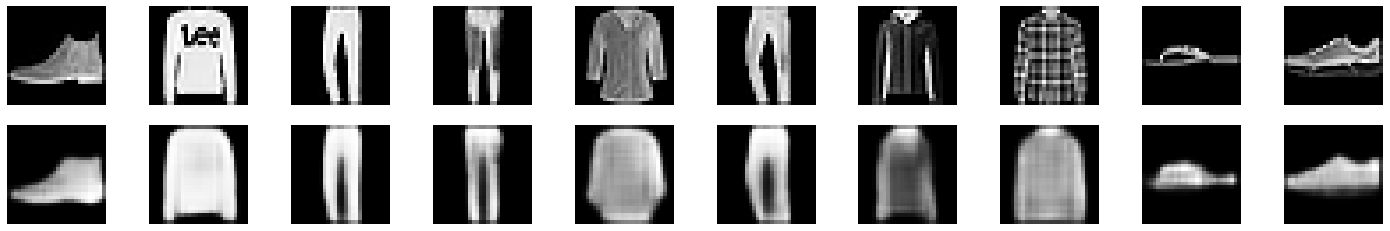

In [62]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(25, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Exercise 2

## Deep CNN

In [63]:
# ========================
#  Data Munging/Reshaping
# ========================
# Load pre-shuffled fashion MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Declaring a depth of 1 for MNIST
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

# Setting up calues as float32s that are bounded between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Processing class labels they are currently a numeric vector
# ----> we need to transform them into categories
print (y_train.shape)
print (y_train[:10])

# We do this through one-hot encoding
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
# Check the shape
print(Y_train.shape)

(60000,)
[9 0 0 3 0 2 7 2 5 5]
(60000, 10)


Here is the Deep CNN architecture. The first layer is  a 2D convolutional layer with filters depth 16, kernel_size (2,2), strides (1,1), activation function 'sigmoid' and padding method 'valid'. Then there is another 2D convolutional layer with filters depth 24, kernel_size (3,3), strides (1,1), activation function 'sigmoid' and padding method 'valid'. Next, we Apply MaxPooling2D with pool_size (2,2) and Dropout(0.25). Then, we flatten all our parameters and add a Dence layer of size 64 with activation function 'relu'. Finally, we add a dropout layer and generate a final output layer of size 10 for the 10 class classification problem.

In [64]:
# =============================
#  Setting up the Architecture
# ============================
# Declaring sequential model
model = Sequential()
# CNN input layer: input_shape: (depth,width,height)
# CNN convolution: number of filters, height and width of kernel
model.add(Conv2D(filters = 16,kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
# Notice here the the first entry output is none
print(model.output_shape)

# Next we add the remaining layers
model.add(Conv2D(filters = 24,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Setting up the fully connected lauer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
print (model.summary())

(None, 27, 27, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 27, 27, 16)        80        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 24)        3480      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 24)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 24)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                221248    
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0 

In [65]:
# =====================
#  Compiling the model
# =====================
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ===================
# Fitting the model
# ===================
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.6639 - acc: 0.7670
Epoch 2/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.4433 - acc: 0.8447
Epoch 3/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.3965 - acc: 0.8592
Epoch 4/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.3666 - acc: 0.8698
Epoch 5/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.3448 - acc: 0.8761
Epoch 6/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.3274 - acc: 0.8815
Epoch 7/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.3136 - acc: 0.8863
Epoch 8/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.2969 - acc: 0.8916
Epoch 9/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.2857 - acc: 0.8960
Epoch 10/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.2749 - a

In [66]:
# =====================
#  Evaluating the model
# =====================
model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 1s 129us/step


[0.24351253509521484, 0.9119]

Here is the evaluation result. We could see that the training error is 0.8997. The test error is 0.9119 which could show that it is a pretty good model. The results are almost correct for this classification problem.

## Transfer learning

In [0]:
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import tensorflow as tf

def grayscale_to_rgb(images, channel_axis=-1):
    images= K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= K.tile(images, tiling)
    return images
 
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Declaring a depth of 1 for MNIST
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# tranfer the greyscale data to rgb and (28,28,3) images to (48,48,3)
x_train = grayscale_to_rgb(X_train)
x_train = tf.image.resize_images(x_train, [48, 48])

x_test = grayscale_to_rgb(X_test)
x_test = tf.image.resize_images(x_test, [48, 48])

sess = tf.Session()
x_train = sess.run(x_train)
x_test= sess.run(x_test)

In [0]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

In [73]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 14,752,330
Trainable params: 37,642
Non-trainable params: 14,714,688
_________________________________________________________________


In [74]:
conv_base.trainable = False
model.trainable_weights

[<tf.Variable 'dense_19/kernel:0' shape=(512, 64) dtype=float32_ref>,
 <tf.Variable 'dense_19/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_20/kernel:0' shape=(64, 64) dtype=float32_ref>,
 <tf.Variable 'dense_20/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_21/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'dense_21/bias:0' shape=(10,) dtype=float32_ref>]

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])

In [76]:
model.fit(x_train, Y_train, epochs=10, batch_size = 128)

Epoch 1/10
60000/60000 [==============================] - 36s 607us/step - loss: 1.8422 - acc: 0.2280
Epoch 2/10
60000/60000 [==============================] - 36s 599us/step - loss: 1.0034 - acc: 0.6471
Epoch 3/10
60000/60000 [==============================] - 36s 595us/step - loss: 0.7089 - acc: 0.7576
Epoch 4/10
60000/60000 [==============================] - 37s 623us/step - loss: 0.6081 - acc: 0.7916
Epoch 5/10
60000/60000 [==============================] - 38s 633us/step - loss: 0.5490 - acc: 0.8121
Epoch 6/10
60000/60000 [==============================] - 36s 601us/step - loss: 0.5081 - acc: 0.8241
Epoch 7/10
60000/60000 [==============================] - 36s 608us/step - loss: 0.4780 - acc: 0.8326
Epoch 8/10
60000/60000 [==============================] - 36s 605us/step - loss: 0.4538 - acc: 0.8388
Epoch 9/10
60000/60000 [==============================] - 36s 606us/step - loss: 0.4346 - acc: 0.8449
Epoch 10/10
60000/60000 [==============================] - 35s 586us/step - loss: 

In [77]:
model.evaluate(x_test, Y_test)

10000/10000 [==============================] - 9s 888us/step


[0.502073261642456, 0.8254]

From above, we could see that the training error after the 10 epoches is 0.8507. The test error is 0.8254 which could show that it is a good model. However, the deep CNN model is better than transfer learning in this way.

# Exercise 3

In [0]:
import urllib
import pandas as pd

# load the data
link1 = "https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt"
link2 = 'https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt'
f = urllib.request.urlopen(link1)
g = urllib.request.urlopen(link2)

# clean the comment, for example, # GOOGLE
benign = f.readlines()
benign = [i[:-1] for i in benign if 35 not in i]
benign_label = list(np.repeat(0,len(benign)))
malicious = g.readlines()
malicious = [i[:-1] for i in malicious]
malicious_label = list(np.repeat(1,len(malicious)))
url_text = benign+malicious
label = benign_label + malicious_label


In [79]:
# create a dataframe for the url and label
# 0 represent the benigh
# 1 represent the malicious
url = pd.DataFrame({'url':url_text, 'label': label})
url.head(5)

,label,url
0,0,b'.0.blogger.gmodules.com'
1,0,b'.0.client-channel.google.com'
2,0,b'.0.docs.google.com'
3,0,b'.0.drive.google.com'
4,0,b'.0.gvt0.cn'


In [0]:
# convert the bytes type url to numerical using one-hot encoding
sample = []
for i in url['url']:
    temp = []
    for j in i:
        temp.append(j)
    sample.append(temp)
      

## RNN

In [0]:
from keras.preprocessing import sequence
# --- Setting up constants ---
# Number of words as features, we keep only the top most-common words
max_features = 10000
# Max number of words in comments (truncate the rest)
max_len = 24 # If not set here, will use the max comment length which is 1132



In [0]:
# split the training set and test set
from sklearn.model_selection import train_test_split
x = sequence.pad_sequences(sample, maxlen = max_len)
y = y_train = url['label']

x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)


y_train = np_utils.to_categorical(Y_train, 2)
y_test = np_utils.to_categorical(Y_test, 2)

In [83]:
# print hte x_train
x_train[0]

array([ 46,  97, 105, 100, 109, 112,  48,  52,  48,  50,  46, 117, 115,
        46, 111, 114,  97,  99, 108, 101,  46,  99, 111, 109], dtype=int32)

In [84]:
# --- Training model: Embedding + RNN ---
model = Sequential()
model.add(Embedding(max_features, max_len))
model.add(SimpleRNN(64))
model.add(Dense(2, activation ='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 24)          240000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                5696      
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 130       
Total params: 245,826
Trainable params: 245,826
Non-trainable params: 0
_________________________________________________________________


In [85]:
# --- Compile Model ---
#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 10, batch_size = 128, 
                    validation_split = 0.25,verbose=1)

Train on 33823 samples, validate on 11275 samples
Epoch 1/10
33823/33823 [==============================] - 6s 189us/step - loss: 0.0944 - acc: 0.9785 - val_loss: 0.4257 - val_acc: 0.8017
Epoch 2/10
33823/33823 [==============================] - 5s 155us/step - loss: 0.0647 - acc: 0.9801 - val_loss: 0.0568 - val_acc: 0.9814
Epoch 3/10
33823/33823 [==============================] - 5s 156us/step - loss: 0.0443 - acc: 0.9829 - val_loss: 0.0533 - val_acc: 0.9813
Epoch 4/10
33823/33823 [==============================] - 5s 156us/step - loss: 0.0319 - acc: 0.9870 - val_loss: 0.0271 - val_acc: 0.9867
Epoch 5/10
33823/33823 [==============================] - 5s 155us/step - loss: 0.0275 - acc: 0.9876 - val_loss: 0.0237 - val_acc: 0.9877
Epoch 6/10
33823/33823 [==============================] - 5s 154us/step - loss: 0.0263 - acc: 0.9885 - val_loss: 0.0306 - val_acc: 0.9861
Epoch 7/10
33823/33823 [==============================] - 5s 155us/step - loss: 0.0247 - acc: 0.9887 - val_loss: 0.0242 - 

In [86]:
# evaluate for the test set
model.evaluate(x_test, y_test)

22213/22213 [==============================] - 4s 165us/step


[0.023528370567215306, 0.9882276144600008]

The accuracy for the model is 0.98822

## CNN

In [87]:
## CNN
# --- Setting up a Sigmoid Sequential Model ---
# Initialize model
model_conv = Sequential()
model_conv.add(Embedding(10000,100, input_length=24))
model_conv.add(Conv1D(128, 2, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Flatten())
model_conv.add(Dense(2, activation='softmax'))
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 128)           25728     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 1282      
Total params: 1,027,010
Trainable params: 1,027,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_conv.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [89]:
model_conv.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 64,validation_split = 0.2)

scores = model_conv.evaluate(x_test, y_test) 
print("%s: %.2f%%" % (model_conv.metrics_names[1], scores[1]*100))

Train on 36078 samples, validate on 9020 samples
Epoch 1/10
36078/36078 [==============================] - 6s 158us/step - loss: 0.0671 - acc: 0.9798 - val_loss: 0.0526 - val_acc: 0.9800
Epoch 2/10
36078/36078 [==============================] - 4s 123us/step - loss: 0.0473 - acc: 0.9822 - val_loss: 0.0476 - val_acc: 0.9813
Epoch 3/10
36078/36078 [==============================] - 4s 124us/step - loss: 0.0421 - acc: 0.9839 - val_loss: 0.0459 - val_acc: 0.9814
Epoch 4/10
36078/36078 [==============================] - 4s 125us/step - loss: 0.0390 - acc: 0.9850 - val_loss: 0.0436 - val_acc: 0.9833
Epoch 5/10
36078/36078 [==============================] - 4s 124us/step - loss: 0.0365 - acc: 0.9861 - val_loss: 0.0473 - val_acc: 0.9827
Epoch 6/10
36078/36078 [==============================] - 5s 125us/step - loss: 0.0338 - acc: 0.9868 - val_loss: 0.0448 - val_acc: 0.9815
Epoch 7/10
36078/36078 [==============================] - 4s 124us/step - loss: 0.0323 - acc: 0.9878 - val_loss: 0.0437 - v

In [90]:
# test accuracy
print("%s: %.2f%%" % (model_conv.metrics_names[1], scores[1]*100))

acc: 98.23%


## Compare the two methods

### RNN and CNN

In [0]:
from sklearn.metrics import roc_curve
y_pred_rnn =model.predict(x_test)
y_pred_cnn =model_conv.predict(x_test)
# convert the categorical 2D to 1D dimension for y_prediction
Y_pred_rnn = []
Y_pred_cnn = []
for i in y_pred_rnn:
  if i[0] >= i[1]:
    Y_pred_rnn.append(0)
  else:
    Y_pred_rnn.append(1)

for i in y_pred_cnn:
  if i[0] >= i[1]:
    Y_pred_cnn.append(0)
  else:
    Y_pred_cnn.append(1)    
fpr_rnn, tpr_rnn, thresholds_r = roc_curve(Y_test, Y_pred_rnn)
fpr_cnn, tpr_cnn, thresholds_c = roc_curve(Y_test, Y_pred_cnn)

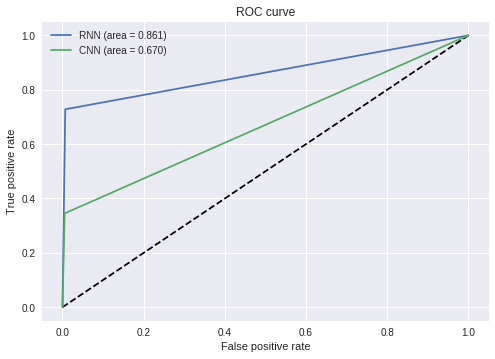

In [92]:
# auc
from sklearn.metrics import auc
auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

From the ROC curve, we could see that the RNN is better than CNN since  the area under the curve of RNN is larger.